# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. This is the dataset to use for this assignment. Note: The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

In [75]:
######################
## Import Libraries ##
######################

import pandas as pd
import numpy as np


############################
## Load and Treat Dataset ##
############################

# Load data:
df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')
# There are no missing values or NaNs in this dataframe!

# Convert date strings to date_time objects:
df['Date'] = pd.to_datetime(df['Date'])
# Data are already from 2005 to 2015! You can chek by running print(df['Date'].min()) and also print(df['Date'].max())

# Convert temperatures to ºC instead of tenth ºC:
df['Data_Value'] = df['Data_Value']/10
# Rename data value column to temperature:
df.rename(columns={'Data_Value': 'Temperature'}, inplace=True)
# Sort by date (ascending):
df.sort_values(by='Date', inplace=True)
# Remove all February 29th data:
df = df[~((df['Date'].dt.month == 2) & (df['Date'].dt.day == 29))]

# Calculate the mean temperature from all locations per date, since we want a temperature for the whole region:
mean_series = df.groupby(['Element', 'Date']).apply(lambda x: x.mean())
# Split data in max and min values:
max_temps = mean_series.loc['TMAX']
min_temps = mean_series.loc['TMIN']

# Split data from 2005 to 2014 and data from 2015:
# Reset index:
max_temps.reset_index(inplace=True)
min_temps.reset_index(inplace=True)
# Temperatures from 2015:
max_2015 = max_temps[max_temps['Date'] >= "2015"]
min_2015 = min_temps[min_temps['Date'] >= "2015"]
# Temperatures up to 2014:
max_temps = max_temps[max_temps['Date'] < "2015"]
min_temps = min_temps[min_temps['Date'] < "2015"]

# Since we want to look at a year frame, remove the year from the date:
max_temps['Date'] = max_temps['Date'].dt.dayofyear
min_temps['Date'] = min_temps['Date'].dt.dayofyear
max_2015['Date'] = max_2015['Date'].dt.dayofyear
min_2015['Date'] = min_2015['Date'].dt.dayofyear
# Obtain max and min values of temperature for each day and drop Date column that appears duplicate:
max_temps = max_temps.groupby('Date').apply(lambda x: x.max()).drop('Date', axis=1)
min_temps = min_temps.groupby('Date').apply(lambda x: x.min()).drop('Date', axis=1)
max_2015 = max_2015.groupby('Date').apply(lambda x: x.max()).drop('Date', axis=1)
min_2015 = min_2015.groupby('Date').apply(lambda x: x.min()).drop('Date', axis=1)

# Rename temperature column for 2015 data to merge:
max_2015.rename(columns={'Temperature': 'Temperature 2015'}, inplace=True)
min_2015.rename(columns={'Temperature': 'Temperature 2015'}, inplace=True)
# Merge 2015 data into 2005-2014 data:
max_temps = pd.merge(max_temps, max_2015, left_index=True, right_index=True, how='inner')
min_temps = pd.merge(min_temps, min_2015, left_index=True, right_index=True, how='inner')

# Just for verification:
max_temps.head()

,Temperature,Temperature 2015
Date,,
1,11.809524,-3.200000
2,8.304762,0.278947
3,8.525000,1.805556
4,8.915000,1.620000
5,10.294737,-1.284211


In [76]:
##################################
## Ajust data for Visualization ##
##################################

## From 2005 to 2014 - line plots ##

# Reset Dates from index to column:
max_temps.reset_index(inplace=True)
min_temps.reset_index(inplace=True)
# Convert integers to timedeltas of days:
max_temps['Date'] = pd.to_timedelta(max_temps['Date'], unit='days')
min_temps['Date'] = pd.to_timedelta(min_temps['Date'], unit='days')
# Add an arbitrary base year (not a leap year) so that we have all days as day and month:
base_date = pd.to_datetime('2013-12-31', yearfirst=True)
max_temps['Date'] += base_date
min_temps['Date'] += base_date


## From 2015 - scatter plot ##

# Get max record breaker values:
max_2015 = max_temps[max_temps['Temperature 2015'] > max_temps['Temperature']]
# Get min record breaker values:
min_2015 = min_temps[min_temps['Temperature 2015'] < min_temps['Temperature']]
# Concatenate record breaking values and dates:
record_breaking = pd.concat([max_2015[['Date', 'Temperature 2015']], min_2015[['Date', 'Temperature 2015']]])

# Just for verification:
print("Max temps:/n")
print(max_temps.head())
print("/nRecord breaking max 2015:/n")
print(record_breaking.head())

Max temps:/n
        Date  Temperature  Temperature 2015
0 2014-01-01    11.809524         -3.200000
1 2014-01-02     8.304762          0.278947
2 2014-01-03     8.525000          1.805556
3 2014-01-04     8.915000          1.620000
4 2014-01-05    10.294737         -1.284211
/nRecord breaking max 2015:/n
          Date  Temperature 2015
99  2014-04-10         19.360000
126 2014-05-07         24.057895
127 2014-05-08         29.026316
128 2014-05-09         29.360000
137 2014-05-18         28.126316


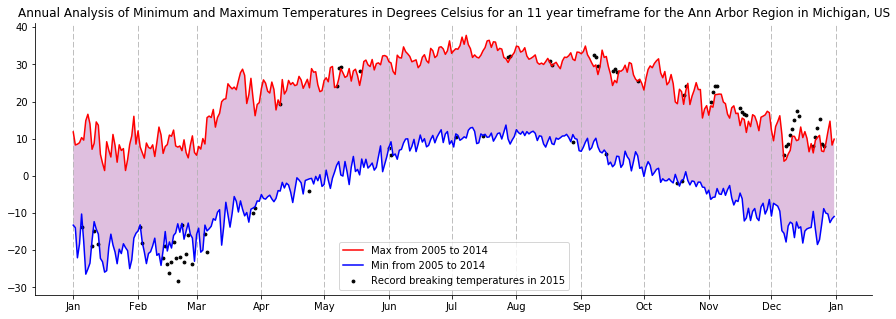

In [104]:
###############
## Plot Data ##
###############

## Import libraries ##

import matplotlib.pyplot as plt
import matplotlib.dates as mdates


## Create figure ##
plt.figure(figsize=(15, 5))


## Create line plots ##
# Max:
plt.plot(max_temps['Date'], max_temps['Temperature'], 'r', label='Max from 2005 to 2014')
# Min:
plt.plot(min_temps['Date'], min_temps['Temperature'], 'b', label='Min from 2005 to 2014')
# Shadow between lines:
plt.gca().fill_between(np.array(max_temps['Date']), min_temps['Temperature'], max_temps['Temperature'],
                       facecolor='purple',
                       alpha=0.25)


## Create 2015 scatter plot ##
plt.scatter(np.array(record_breaking['Date']), record_breaking['Temperature 2015'],
            label='Record breaking temperatures in 2015', c='black', s=8)


## Finalize Visual ##
plt.title("Annual Analysis of Minimum and Maximum Temperatures in Degrees Celsius for an 11 year timeframe for the Ann Arbor Region in Michigan, US")
plt.legend()

# Formatting x axis:
# Define month locator for x axis data:
locator = mdates.MonthLocator()
# Define desired format (%b gives written month names abreviations):
fmt = mdates.DateFormatter('%b')
# Get x axis object:
x_axis = plt.gca().xaxis
# Set locator:
x_axis.set_major_locator(locator)
# Set formatter:
x_axis.set_major_formatter(fmt)
# Set vertical grid:
x_axis.grid(True, linestyle='--')

# Hide top and right sipnes:
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

## Save and show image ##
plt.show()
#plt.savefig('temperature_analysis.png')

# TODO: Shadow between lines
# TODO: Texts, legends, titles, temove contours.... make final appearance of graphic nice